In [3]:
import networkx as nx
from geopy.distance import great_circle
import geohash
import geopandas as gpd
import osmnx as ox
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import math
import contextily as cx
from shapely.geometry import Polygon,Point
from shapely import wkt,ops
import colorsys
from sklearn.preprocessing import StandardScaler
from scipy import spatial
import random

In [1]:
import matplotlib

In [6]:
plt.rcParams['font.sans-serif'] = ['Helvetica'] 

## Read In Data
Origin-Destination data should have the following columns
<ul>
    <li><b>start_geohash5</b>: description</li>
    <li><b>end_geohash5</b>: description</li>
    <li><b>local_time</b>: description</li>
    <li><b>m_length_m</b>: description</li>
</ul>

We use Colombia as an example country, but ```daily_od_fname``` should consist of the path to your OD file

In [ ]:
country_name = 'colombia'
country_abbrv = 'co'
daily_od_fname = f'od_{country_abbrv}_agg5_3h.csv'

In [9]:
daily_od = pd.read_csv(daily_od_fname)
geohashes = list(set(daily_od.start_geohash5.unique()).union(set(daily_od.end_geohash5.unique())))
geohash_coord = {gh:geohash.decode(gh) for gh in geohashes}
geohash_bbox = {gh: geohash.bbox(gh) for gh in geohashes}

/home/jupyter-niyer/README


In [6]:
bbox_gdf = gpd.GeoDataFrame([[gh, Polygon([(geohash_bbox[gh]['w'], geohash_bbox[gh]['s']),
                                     (geohash_bbox[gh]['e'], geohash_bbox[gh]['s']),
                                     (geohash_bbox[gh]['e'], geohash_bbox[gh]['n']), 
                                     (geohash_bbox[gh]['w'], geohash_bbox[gh]['n'])])] for gh in geohashes],
                       columns=['gh5', 'geometry'], geometry='geometry', crs="EPSG:4326")

In [150]:
unique_times = list(np.unique([row.local_time[-19:] for i, row in daily_od.iterrows()]))
str_time_dict = {t:i for i, t in enumerate(unique_times)}
daily_od['time_id'] = daily_od.local_time.apply(lambda x: str_time_dict[x[-19:]])
daily_od['m_length_km'] = daily_od.m_length_m/1000.
daily_od['neighbours'] = daily_od['start_geohash5'].apply(lambda x: geohash.neighbors(x))


# Create Graph

In [8]:
def euclidean_distance(pos1, pos2):
    return math.sqrt((pos1[0] - pos2[0]) ** 2 + (pos1[1] - pos2[1]) ** 2)

def find_closest_node(G, source, source_pos):
    closest_node = None
    min_distance = float('inf')

    for node in G.nodes:
        if node == source:
            continue
        node_pos = G.nodes[node]['pos']
        distance = euclidean_distance(source_pos, node_pos)
        if distance < min_distance:
            min_distance = distance
            closest_node = node

    return closest_node, min_distance

In [9]:

G = nx.Graph()

# Add nodes with coordinates as attributes
for gh, (lat, lon) in geohash_coord.items():
    G.add_node(gh, pos=(lat, lon))

for geo1 in geohashes:
    for geo2 in geohash.neighbors(geo1):
        
        pos1 = geohash_coord[geo1]
        if geo2 in geohashes: 
            pos2 = geohash_coord[geo2]
            distance = great_circle(pos1, pos2).meters
        
            G.add_edge(geo1, geo2, weight=distance)

Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
print(len(G.subgraph(Gcc[0]).nodes),len(G.subgraph(Gcc[1]).nodes),len(G.subgraph(Gcc[2]).nodes) )


139 92 77


In [10]:
Gcc = [G.subgraph(gc) for gc in sorted(nx.connected_components(G), key=len, reverse=False)]
size_gcc = {}
for gc in Gcc:
    size = len(gc.nodes)
    if size in size_gcc.keys():
        size_gcc[size].append(gc)
    else:
        size_gcc[size] = [gc]

In [ ]:
for gc in Gcc[:-1]:
    
    gc_size = len(gc.nodes)
    bigger_comps = [gv for k, v in size_gcc.items() if k>gc_size for gv in v]
    pot_nodes = set()
    for bc in bigger_comps:
        pot_nodes = pot_nodes.union(set(bc.nodes))
    pot_G = G.subgraph(pot_nodes)


    connecting_node = []
    for node in gc:
        # print(pot_G.nodes, node, geohash_coord[node])
        closest_node,_ = find_closest_node(pot_G, node, geohash_coord[node])
        print(closest_node)
        distance = great_circle(geohash_coord[node],geohash_coord[closest_node]).meters
        connecting_node += [[node, closest_node, distance]]
        
    connecting_node = pd.DataFrame(connecting_node,
                                columns=['gh5','closest_node', 'dist']).sort_values('dist')
    print('connecting node',node, 'to ', connecting_node.iloc[0]['closest_node'])
    G.add_edge(node, connecting_node.iloc[0]['closest_node'], weight=connecting_node.iloc[0]['dist'])

In [2]:
## Make sure there is only one component in the graph
len(sorted(nx.connected_components(G), key=len, reverse=True)) == 1

## Visualise Graph

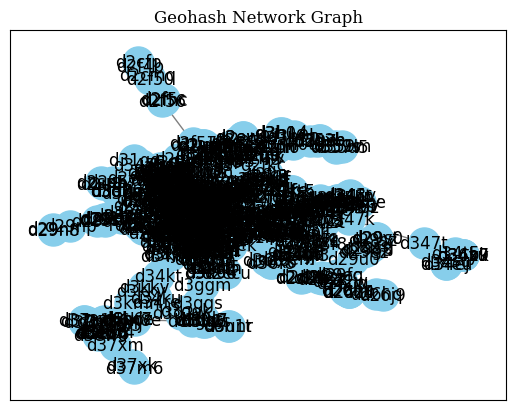

In [15]:
pos = nx.spring_layout(G, seed=42)  # positions for all nodes

nx.draw_networkx_nodes(G, pos, node_size=500, node_color='skyblue')
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

plt.title('Geohash Network Graph')
plt.show()

## Percolation

In [27]:
import networkx as nx
import numpy as np
from math import radians, sin, cos, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2]) # degrees to radians
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    radius = 6371  # Earths radius (km)
    return radius * c

def hierarchical_percolation(G, distance_threshold):
    """
    Parameters:
    - G: A NetworkX graph where each node has 'lat' and 'lon' attributes.
    - distance_threshold: The maximum distance (in kilometers) for nodes to be considered in the same cluster.

    Returns:
    - A list of clusters, where each cluster is a set of node identifiers.
    """

    clusters = []
    visited = set()

    def find_neighbors(node, cluster):
        """Recursively find all neighbors within the distance threshold."""
        for neighbor in G.nodes():
            if neighbor not in visited:
                node_lat,node_lon = G.nodes[node]['pos']
                neighbour_lat,neighbour_lon = G.nodes[neighbor]['pos']
                dist = great_circle((node_lat, node_lon),
                                 (neighbour_lat, neighbour_lon)).km
                if dist <= distance_threshold:
                    # print(dist,distance_threshold)
                    visited.add(neighbor)
                    cluster.add(neighbor)
                    find_neighbors(neighbor, cluster)

    # Iterate over all nodes to build clusters
    for node in G.nodes():
        if node not in visited:
            visited.add(node)
            cluster = set([node])
            find_neighbors(node, cluster)
            # print(len(cluster))
            clusters.append(cluster)
    
    return clusters, len(clusters)

In [ ]:
perc_clusters = {}
n_clusters = []
largest_cluster_size, largest_cluster_size_norm = [],[]
for dist in np.arange(0,100,2):
    if dist%10==0:
        print(dist)
    x = hierarchical_percolation(G, dist)
    n_clusters.append(x[1])
    perc_clusters[dist] = x[0]
    largest_cluster_size.append(sorted([len(xx) for xx in x[0]])[-1])
    largest_cluster_size_norm.append(sorted([len(xx) for xx in x[0]])[-1]/len(G.nodes))

In [15]:
perc_clusters.keys()

dict_keys([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98])

In [13]:
def find_large_slope_changes(xs, ys, threshold=1.0, increase=True, real_changes=False):
    slopes = np.diff(ys) / np.diff(xs)
    slope_changes = np.abs(np.diff(slopes))
    changes = np.where(slope_changes > threshold)[0] + 1
    print(changes)
    if real_changes:
        rcs = []
        i = 0
        while i < len(changes)-1:
        
            temp_i = i
            while changes[temp_i]+1 >= int(changes[temp_i+1]):
                if temp_i >= len(changes)-2:
                    break
                temp_i+=1
                print(changes[temp_i], changes[temp_i+1])
            print('adding', changes[i]/2, 'at', i, 'skipping to', temp_i)
            if increase:
                rcs.append(changes[i]/2)
            else:
                rcs.append((changes[i]/2)+0.5)
            i=temp_i+1
        return rcs
    else:
        return changes/2+1

In [14]:
def cluster_close_indices(indices, min_distance=3):
    clusters = []
    current_cluster = [indices[0]]

    for idx in indices[1:]:
        if idx - current_cluster[-1] <= min_distance:
            current_cluster.append(idx)
        else:
            clusters.append(current_cluster)
            current_cluster = [idx]
    
    if current_cluster:
        clusters.append(current_cluster)
    
    return clusters
     
def find_large_slope_changes(x, y):
    # 1. Compute the slope (dy/dx)
    dy = np.diff(y)  
    dx = np.diff(x)  
    slope = dy / dx 
    
    # 2. Compute the relative slope increases
    slope_change = np.diff(slope) 
    relative_slope_increases = np.maximum(slope_change, 0)  # only positive increases
    
    # 3. Identify the top 25% slope increases
    percentile_75 = np.percentile(relative_slope_increases, 75)
    top_slope_indices = np.where(relative_slope_increases >= percentile_75)[0]
    
    # Define minimum distance between top increases (e.g., 3 points)
    min_distance = 3
    clusters = cluster_close_indices(top_slope_indices, min_distance)
    print(clusters)
    # 4. For each cluster, get the largest slope and its index
    largest_in_each_cluster = [(max(cluster, key=lambda idx: slope[idx]), slope[max(cluster, key=lambda idx: slope[idx])]) for cluster in clusters]
    largest_indices = [idx for idx, _ in largest_in_each_cluster]

    return [x[fti + 1] for fti in largest_indices],[y[fti + 1] for fti in largest_indices]

In [16]:
rcs = find_large_slope_changes(list(perc_clusters.keys()), largest_cluster_size)
rcs

[[1], [5, 6, 9], [14, 16], [23], [27], [32, 35]]


([4, 14, 34, 48, 56, 72], [1, 578, 2337, 2575, 2937, 3387])

In [234]:
from io import BytesIO


/home/jupyter-niyer/README
Variable data is successfully uploaded as 'netmob_2024/final_figures/processing/mx_percolation_cluster_size.pdf' to bucket 'niyer-processed'.


/tmp/ipykernel_2722041/2941539569.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)
/tmp/ipykernel_2722041/2941539569.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=15)


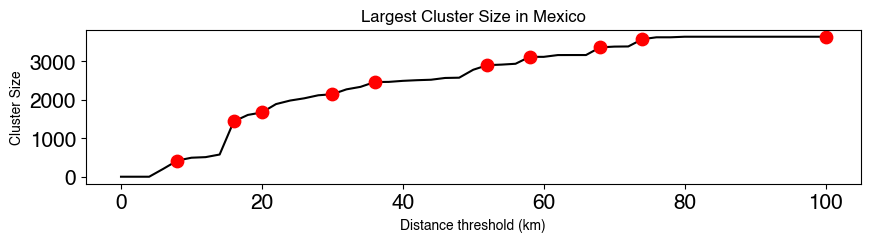

In [235]:
rcs = find_large_slope_changes(np.arange(1,100,0.5), largest_cluster_size, threshold=40, real_changes=True)
fig,ax=plt.subplots(figsize=(10,2))

ax.plot(perc_clusters.keys(), largest_cluster_size, color='k', zorder=0)
ax.set_title('Largest Cluster Size in ' + country_name.title())
ax.set_xlabel('Distance threshold (km)')
ax.set_ylabel('Cluster Size')

xs = rcs[0]


ax.scatter(xs, [largest_cluster_size[int(x/2)] for x in xs], color='red', alpha=1, zorder=1, s=80)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=15)


# plt.savefig(f'{country_abbrv}_percolation_cluster_size.pdf', format='pdf', bbox_inches='tight')

## Visualise Clusters

In [ ]:
country_abbrv ='co'
country_name = 'colombia'
n_clusters = [len(v) for k,v in perc_clusters.items()]
largest_cluster_size = [max([len(vv) for vv in v]) for k,v in perc_clusters.items()]

In [ ]:
geohashes = list(set(daily_od.start_geohash5.unique()).union(set(daily_od.end_geohash5.unique())))
geohash_coord = {gh:geohash.decode(gh) for gh in geohashes}
geohash_bbox = {gh: geohash.bbox(gh) for gh in geohashes}

In [10]:
geohash_gdf = gpd.GeoDataFrame([[gh, Polygon([(geohash_bbox[gh]['w'], geohash_bbox[gh]['s']),
                                     (geohash_bbox[gh]['e'], geohash_bbox[gh]['s']),
                                     (geohash_bbox[gh]['e'], geohash_bbox[gh]['n']), 
                                     (geohash_bbox[gh]['w'], geohash_bbox[gh]['n'])])] for gh in geohashes],
                       columns=['gh5', 'geometry'], geometry='geometry', crs="EPSG:4326")

In [11]:
from io import BytesIO
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [12]:
perc_gdf = {}
for distance_thresh, perc_groups in perc_clusters.items():
    geohash_cluster = {gh: cl for cl, ghs in enumerate(perc_groups) for gh in ghs}
    perc_cl_gdf = geohash_gdf.copy()
    perc_cl_gdf['cluster'] =  [geohash_cluster[row.gh5] for i,row in geohash_gdf.iterrows()]
    perc_gdf[distance_thresh] = perc_cl_gdf

In [13]:
def draw_cluster_boundaries(gdf, perc_level, cluster_column, no_urban, crs, ca, cluster_type='biggest', draw=True, title=None, save=False):

    x= gdf.copy()
    x['size']=x.geometry.area
    x = x.groupby(cluster_column).agg({'size':'sum', 'gh5':'count'}).reset_index()

    if cluster_type=='biggest':
        clusters = x.sort_values('size', ascending=False).iloc[:no_urban][cluster_column]
    elif cluster_type=='smallest':
        clusters = x.sort_values('size', ascending=False).iloc[no_urban:]#[cluster_column]
        clusters = clusters[clusters.gh5>=1][cluster_column]
    else:
        clusters = gdf[cluster_column].unique()
        
        
    
    boundaries_gdf = gpd.GeoDataFrame(columns=['geometry', 'cluster'], crs=crs)
    boundaries_gdf = boundaries_gdf.to_crs('EPSG:21899')
    print(gdf.crs)

    cluster_gh5 = {}
    for cluster in clusters:
        # Combine all geometries in this cluster
        cluster_gh5[cluster] = list(gdf[gdf[cluster_column] == cluster].gh5.unique())
        cluster_geom = ops.unary_union(gdf[gdf[cluster_column] == cluster].geometry)
        
        # Get the boundary of the combined geometry
        boundary = cluster_geom.boundary
        
        # Add the boundary 
        boundaries_gdf = pd.concat([boundaries_gdf, pd.DataFrame([[cluster_geom,cluster]],
                                                                 columns=['geometry', 'cluster'])], ignore_index=True)

    if draw:
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

        gdf[gdf.cluster.isin(clusters)].plot(ax=ax, column=cluster_column,  categorical=True,
                                                     cmap='Dark2', zorder=1)#, edgecolor='k', alpha=0.5)
        
    
        ax.add_feature(cfeature.LAND, zorder=0, edgecolor='k', facecolor='white', linewidth=0.1)
        
        ax.add_feature(cfeature.STATES, zorder=0, edgecolor='k', facecolor='white', linewidth=0.1)

        
        plt.axis('off')
        print(plt.xlim(),plt.ylim())
        if ca=='co':
            plt.xlim((-76.93505859375, -72.39111328125))
            plt.ylim((2.533447265625, 11.572998046875))
        if ca=='mx':
            plt.xlim((-118.680908203125, -85.181396484375))
            plt.ylim((14.853271484375, 33.497314453125))
        if ca=='in':
            plt.xlim((71.404541015625, 89.819091796875))
            plt.ylim((7.19384765625, 32.62060546875))
        if save:
            plt.savefig(f'{country_abbrv}_urban_areas_{perc_level}.pdf', format='pdf', bbox_inches='tight')
    return list(gdf[gdf.cluster.isin(clusters)].gh5), cluster_gh5, boundaries_gdf

/tmp/ipykernel_296381/2925873751.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  x['size']=x.geometry.area
/tmp/ipykernel_296381/2925873751.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  x['size']=x.geometry.area


EPSG:4326
(-76.7724609375, -72.9052734375) (2.814697265625, 11.467529296875)
EPSG:4326
(-76.93505859375, -72.39111328125) (2.533447265625, 11.572998046875)
EPSG:4326


/tmp/ipykernel_296381/2925873751.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  x['size']=x.geometry.area


(-82.452392578125, -66.741943359375) (-0.123046875, 13.21875)


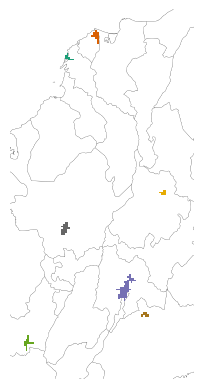

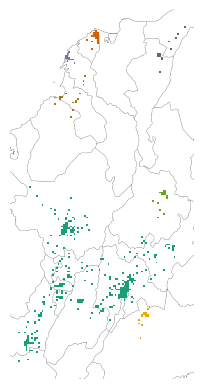

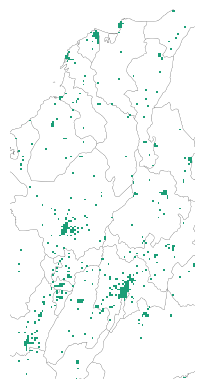

In [17]:
for x in [6,36,98]:
    urban_areas,urban_clusters,urban_bounds_gdf =draw_cluster_boundaries(perc_gdf[x], x, 'cluster',country_no_urban[country_name],country_proj[country_name],
                                                                         country_abbrv,
                                                                         cluster_type='biggest', draw=True, title='Urban Areas', save=False)

# Find closest city for each rural area

In [ ]:
urban_areas,urban_clusters,urban_bounds_gdf =draw_cluster_boundaries(perc_gdf[urban_perc], urban_perc, 'cluster',country_no_urban[country_name],country_proj[country_name],
                                                                         ca=country_abbrv, cluster_type='biggest', draw=True, title='Urban Areas', save=False)

In [58]:
def find_closest_city(urban_bounds_gdf, rural_bounds_gdf):
    proximity_df = pd.DataFrame(index=rural_bounds_gdf.cluster, columns=urban_bounds_gdf.cluster)
    for ui, urow in urban_bounds_gdf.iterrows():
        for ru, rrow in rural_bounds_gdf.iterrows():
            u_lon, u_lat = urow['geometry'].centroid.x, urow['geometry'].centroid.y
            r_lon, r_lat = rrow['geometry'].centroid.x, rrow['geometry'].centroid.y
            proximity_df.loc[rrow.cluster, urow.cluster] = haversine(u_lat, u_lon, r_lat, r_lon)

    proximity = pd.DataFrame([[i,row.idxmin()] for i,row in proximity_df.iterrows()], 
                             columns=['rural_cid', 'closest_city'])
    
    return proximity, proximity_df

In [59]:
closest_city, closest_city_df = find_closest_city(urban_bounds_gdf, rural_bounds_gdf)
urbanicity_df = urbanicity_df.merge(closest_city, how='left', 
                                    left_on='cluster_id', right_on='rural_cid').drop('rural_cid',axis=1)
urbanicity_df

,gh5,cluster_id,area_type,closest_city
0,ttjrg,0,rural,58.0
1,whdej,1,rural,15.0
2,tek94,2,urban,NaN
3,tetxx,3,rural,138.0
4,texvu,4,rural,147.0
...,...,...,...,...
3519,tepes,99,urban,NaN
3520,tepu1,99,urban,NaN
3521,tdr9g,1763,rural,81.0
3522,tg8qt,1764,rural,147.0


In [61]:
urbanicity_df.to_csv(f'{country_abbrv}_urbanicity_v2.csv', urbanicity_df)

/home/jupyter-niyer/README
Variable data is successfully uploaded as 'netmob_2024/processed_data/in_urbanicity_v2.csv' to bucket 'niyer-processed'.
